# Dimensionality Reduction, with PCA

> Matrix Decomposition, or Matrix Factorization  
> _Factorization_ means to find two (or three) matrices to approximate the original matrix $X$  

+ Dimensionality: dimensions/features/columns of a table  
+ PCA: Principal Component Analysis 


In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

## Dimensionality Reduction

+ Matrix Decomposition, or Matrix Factorization
+ Given a matrix $X$ of shape $m$ by $n$, reduce its dimension to have shape $m$ by $p$, where $p \le n$
+ Mathmatically, _factorization_ is about finding two (or three) matrices to approximate the original matrix $X$


### When do we need Dimensionality Reduction? 

+ Handle data with large number of features, e.g. NLP, Image Processing or larger tables
+ Visualize data of more than 3 dimensions

Note: after PCA, the features become less interpretable

### Other Reduction Algorithms 

(by `sklearn.decomposition`)

+ `PCA`, principal component analysis
+ `Kernel PCA`; PCA with kernel tricks to perform non-linear dimensinality reduction
+ `SVD`, singular value decomposition; the fundamental algorithm for decomposition in PCA
+ `NMF`, non-negative matrix factorization; contstrained to run only on non-negative matrix
+ ... 

(by `sklearn.discriminant_analysis`)

+ `LDA`, Linear Discriminant Analysis, finding the plane in feature space to separate the data points
+ ...

## PCA Intuitions with visualization

+ Given a matrix of shape $m$ by $\boldsymbol{3}$, 
  + reduce its dimension to have shape $m$ by $\boldsymbol{2}$
  + reduce its dimension to have shape $m$ by $\boldsymbol{1}$

### 3 Dimension data

In [34]:
# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t) + 3 , np.sin(t) + 10, t # transform so all >= 0

X = np.c_[x, y, z]; row_index = np.array(range(X.shape[0]))
display(X.shape)
X[:5, :]

(50, 3)

array([[ 4.        , 10.        ,  0.        ],
       [ 3.97924752, 10.20266794,  0.20408163],
       [ 3.91785141, 10.39692415,  0.40816327],
       [ 3.81835992, 10.57470604,  0.6122449 ],
       [ 3.68490244, 10.72863478,  0.81632653]])

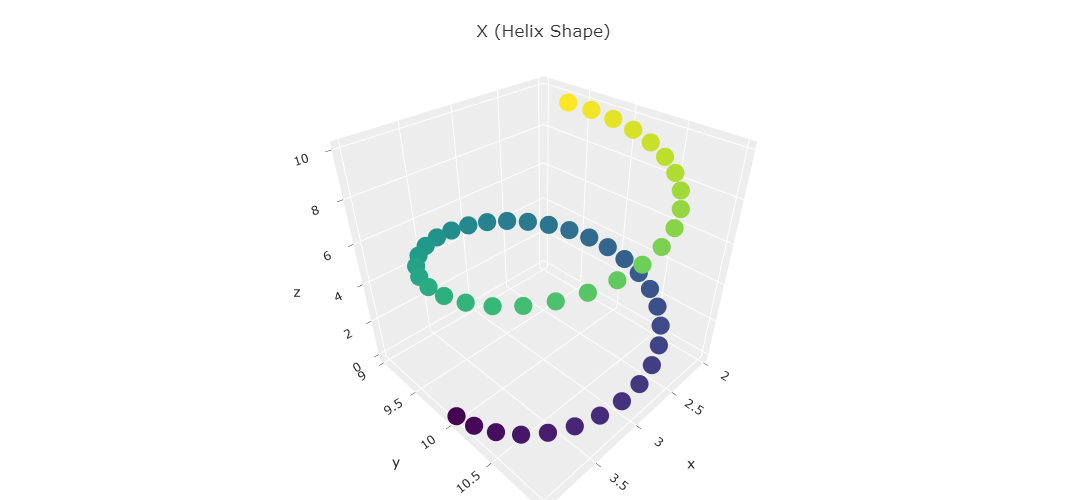

In [35]:
#@title (plot helix shape) { display-mode: "form" }
trace1 = go.Scatter3d(
    x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers', 
    marker=dict(size=5,  color=row_index, colorscale='Viridis',)
)

layout = dict(
    title=dict(text="X (Helix Shape)", y=0.95), 
    height=500, width=500, autosize=False,
    margin=dict(l=0, r=0, b=0, t=30),
    template="ggplot2",
    scene=dict(
        aspectmode="cube", # for 3d viewing 
    ), 
)

fig = go.Figure(data=[trace1], layout=layout)
fig.show(config={'displayModeBar': False, 'scrollZoom': False})

# Q: how to reduce from 3D to 2D, while keeping the most information on new axes? 

In [36]:
pca_2d = PCA(n_components=2)
pca_1d = PCA(n_components=1)

X_reduced_2d = pca_2d.fit_transform(X)
X_reduced_1d = pca_1d.fit_transform(X)

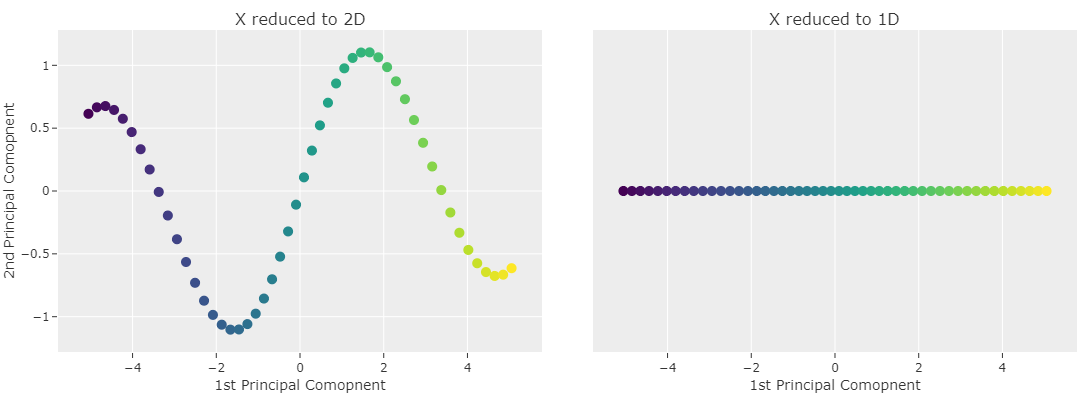

In [37]:
#@title (plot dimensionality reduced helix shape) { display-mode: "form" }
trace1 = go.Scatter(
    x=X_reduced_2d[:, 0], y=X_reduced_2d[:, 1], mode='markers', 
    marker=dict(size=10, color=row_index, colorscale='Viridis',)
)
trace2 = go.Scatter(
    x=X_reduced_1d[:, 0], y=[0] * X_reduced_1d.shape[0], mode='markers', 
    marker=dict(size=10, color=row_index, colorscale='Viridis',)
)

layout = {
    "height": 400, "width": 1000, 'autosize': False,
    "margin": dict(l=10, r=10, b=10, t=30), 
    "template": "ggplot2", "showlegend": False, 
    "xaxis": {"fixedrange": True, "title": {"text": "1st Principal Comopnent", "standoff": 5}}, 
    "yaxis": {"fixedrange": True, "title": {"text": "2nd Principal Comopnent", "standoff": 0}}, 
    "xaxis2": {"fixedrange": True,"title": {"text": "1st Principal Comopnent", "standoff": 5}}, 
    "yaxis2": {"fixedrange": True, "visible": False}, 
}

fig = make_subplots(
    rows=1, cols=2,  horizontal_spacing=0.05,
    subplot_titles=("X reduced to 2D", "X reduced to 1D")
)
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.update_layout(layout)
fig.show(config={'displayModeBar': False, 'scrollZoom': False})

# Q: what is the information kept here? 

## PCA with `numpy`

1. **Center the data, so each feature having `mean = 0`**
  + optionally, scaling the data so each feature having `standard deviation = 1`
2. **Compute the covariance matrix on each feature**
  + get the variance within a feature
  + get the co-variance between two features
  + optionally, using correlation matrix
3. **Compute egenvalues and eigenvectors on the covariance matrix**
  + get eigenvalues, as the importance of each component
  + get eigenvectors, as the components
4. **Sort eigenvectors by eigenvalues (from largest to smallest)**
  + get ordered eigenvectors, the first vector is the _first Principal Component_
5. **Transform the original data**
  + slice the eigenvectors by number of principal components to use
  + construc reduced data by dot product between data and sliced eigenvectors

In [38]:
def numpy_pca(X, n_components, scaled=False):
    
    """
    Return dimensions reduced data by specified dimension
    
    INPUTS: 
        X - 2D numpy array of shape (m, n)
        n_components - int of number of dimensions to reduce
                       to, must <= n
    OUTPUTS: 
        eigen_vals - 1D numpy array of length n, sorted
                     from largest to smallest
        eigen_vecs - 2D numpy array of shape (n, n), sorted
                     by eigen_vals from largest to smallest
        reduced_X - 2D numpy array of shape (m, n_components), 
                    i.e. the dimensinality reduced X 
    """
    
    assert X.shape[1] >= n_components, \
        "n_components must be smaller or equal to number of dimensions in X"
    
    # 1. Center the data, so each feature having mean = 0
    data = X - np.mean(X, axis=0)
    
    if scaled: 
        data = data / np.std(data, axis=0)
    
    # 2. Compute the covariance matrix on each feature
    covariance_matrix = np.cov(data, rowvar=False)
    
    # 3. Compute egenvalues and eigenvectors on the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)
    
    # 4. Sort eigenvectors by eigenvalues (from largest to smallest)
    idx = np.argsort(eigen_vals)[::-1] # sort eigen values from largest to smallest
    eigen_vecs = eigen_vecs[:,idx] # order by sorted index
    eigen_vals = eigen_vals[idx]
    
    reduced_vecs = eigen_vecs[:, :n_components]
    
    # 5.Transform the original data
    reduced_X = np.dot(data, reduced_vecs)
    
    return eigen_vals, eigen_vecs, reduced_X

In [39]:
# test the function 
_, _, np_X_reduced_2d = numpy_pca(X, 2, scaled=False)
_, _, np_X_reduced_1d = numpy_pca(X, 1, scaled=False)

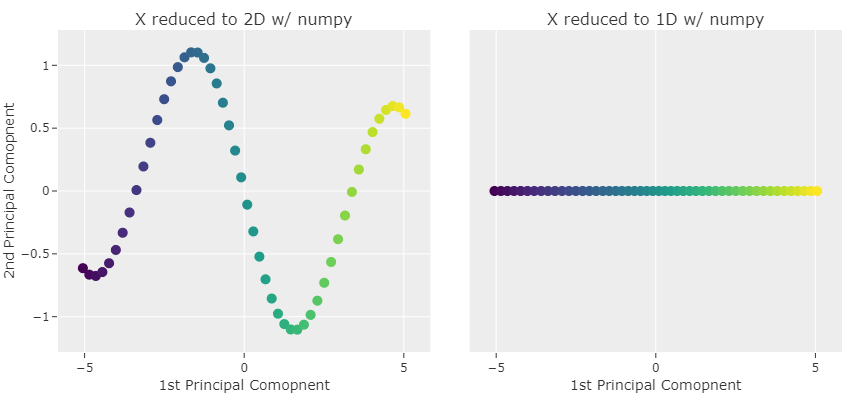

In [40]:
#@title (plot dimensionality reduced helix shape with numpy_pca) { display-mode: "form" }
trace1 = go.Scatter(
    x=np_X_reduced_2d[:, 0], y=np_X_reduced_2d[:, 1], mode='markers', 
    marker=dict(size=10, color=row_index, colorscale='Viridis',)
)
trace2 = go.Scatter(
    x=np_X_reduced_1d[:, 0], y=[0] * np_X_reduced_1d.shape[0], mode='markers', 
    marker=dict(size=10, color=row_index, colorscale='Viridis',)
)
layout = dict(
    height=400, width=1000, autosize=False,
    margin=dict(l=10, r=10, b=10, t=30), 
    template="ggplot2", showlegend=False, 
    xaxis={"fixedrange": True, "title": {"text": "1st Principal Comopnent", "standoff": 5}}, 
    yaxis={"fixedrange": True, "title": {"text": "2nd Principal Comopnent", "standoff": 0}}, 
    xaxis2={"fixedrange": True,"title": {"text": "1st Principal Comopnent", "standoff": 5}}, 
    yaxis2={"fixedrange": True, "visible": False}, 
)

fig = make_subplots(
    rows=1, cols=2, horizontal_spacing=0.05,
    subplot_titles=("X reduced to 2D w/ numpy", "X reduced to 1D w/ numpy")
)
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.update_layout(layout)
fig.show(config={'displayModeBar': False, 'scrollZoom': False})

## PCA with high-dimension data

> Wine Data: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html  
> 13 features, classify wine quality by given features   

+ **With features of different units, it's suggested to _standarize_ before applying PCA**
  + standarization = centering + scaling
  + `sklearn.decomposition.PCA` only centers data


In [41]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

In [42]:
X, y = load_wine(return_X_y=True)
X.shape, y.shape

((178, 13), (178,))

In [43]:
(
    pd.DataFrame(X).describe().iloc[1:, :]
    .style.applymap(lambda s: 'color: red' if s >= 100 else '')
    .format("{0:,.4f}") # well, styler doesn't work with colab extension
).data.round(4)
# note the last feature has different units than others 

,0,1,2,3,4,5,6,7,8,9,10,11,12
mean,13.0006,2.3363,2.3665,19.4949,99.7416,2.2951,2.0293,0.3619,1.5909,5.0581,0.9574,2.6117,746.8933
std,0.8118,1.1171,0.2743,3.3396,14.2825,0.6259,0.9989,0.1245,0.5724,2.3183,0.2286,0.7100,314.9075
min,11.0300,0.7400,1.3600,10.6000,70.0000,0.9800,0.3400,0.1300,0.4100,1.2800,0.4800,1.2700,278.0000
25%,12.3625,1.6025,2.2100,17.2000,88.0000,1.7425,1.2050,0.2700,1.2500,3.2200,0.7825,1.9375,500.5000
50%,13.0500,1.8650,2.3600,19.5000,98.0000,2.3550,2.1350,0.3400,1.5550,4.6900,0.9650,2.7800,673.5000
75%,13.6775,3.0825,2.5575,21.5000,107.0000,2.8000,2.8750,0.4375,1.9500,6.2000,1.1200,3.1700,985.0000
max,14.8300,5.8000,3.2300,30.0000,162.0000,3.8800,5.0800,0.6600,3.5800,13.0000,1.7100,4.0000,1680.0000


### Using PCA for visualization

+ the importance of scaling data

In [44]:
pca_wine_3d = PCA(n_components=3)
wine_X_3d = pca_wine_3d.fit_transform(X)

scaler = StandardScaler()
pca_wine_3d_scaled = PCA(n_components=3)
wine_X_3d_scaled = pca_wine_3d_scaled.fit_transform(scaler.fit_transform(X))

wine_X_3d.shape, wine_X_3d_scaled.shape

((178, 3), (178, 3))

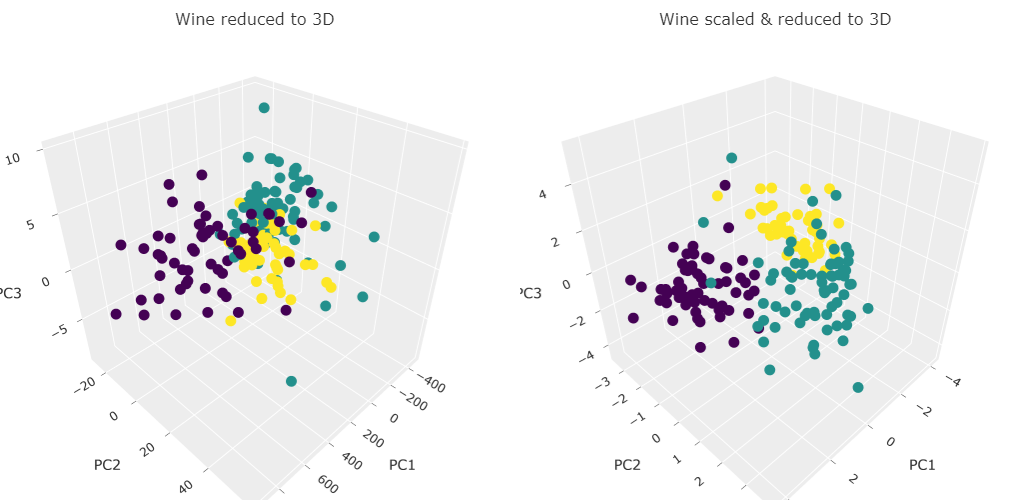

In [45]:
trace1 = go.Scatter3d(
    x=wine_X_3d[:, 0], y=wine_X_3d[:, 1], z=wine_X_3d[:, 2], mode='markers', 
    marker=dict(size=3,  color=y, colorscale='Viridis',)
)
trace2 = go.Scatter3d(
    x=wine_X_3d_scaled[:, 0], y=wine_X_3d_scaled[:, 1], z=wine_X_3d_scaled[:, 2], 
    mode='markers', 
    marker=dict(size=3,  color=y, colorscale='Viridis',)
)
layout = dict(
    height=500, width=1000, autosize=False,
    margin=dict(l=0, r=0, b=0, t=30),
    template="ggplot2", showlegend=False,
)
scenes = {
    "scene": dict(xaxis_title="PC1", yaxis_title="PC2", 
                  zaxis_title="PC3", aspectmode="cube"),
    "scene2": dict(xaxis_title="PC1", yaxis_title="PC2",
                   zaxis_title="PC3", aspectmode="cube"),
}

fig = make_subplots(
    rows=1, cols=2, horizontal_spacing=0.01,
    subplot_titles=("Wine reduced to 3D", "Wine scaled & reduced to 3D"), 
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]]
)
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.update_layout(layout)
fig.update_layout(scenes)
fig.show(config={'displayModeBar': False, 'scrollZoom': False})

# Note: the left chart has different units and classes are hardly separable

### Finding the number of components to reduce

+ the importance of scaling data
+ `explained_variance_`
+ `explained_variance_ratio_`

In [46]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [47]:
pca_wine = PCA()
pca_wine_scaled = PCA()

pca_wine.fit(X)
pca_wine_scaled.fit(scaled_X)

display(pca_wine.explained_variance_.round(4))
display(pca_wine_scaled.explained_variance_)

array([9.92017895e+04, 1.72535300e+02, 9.43810000e+00, 4.99120000e+00,
       1.22880000e+00, 8.41100000e-01, 2.79000000e-01, 1.51400000e-01,
       1.12100000e-01, 7.17000000e-02, 3.76000000e-02, 2.11000000e-02,
       8.20000000e-03])

array([4.73243698, 2.51108093, 1.45424187, 0.92416587, 0.85804868,
       0.64528221, 0.55414147, 0.35046627, 0.29051203, 0.25232001,
       0.22706428, 0.16972374, 0.10396199])

In [48]:
scaled_exp_var = pca_wine_scaled.explained_variance_
exp_var = pca_wine.explained_variance_

pd.DataFrame(
    [exp_var, 
     exp_var.cumsum() / exp_var.sum(), # pca_wine.explained_variance_ratio_
     scaled_exp_var,  
     scaled_exp_var.cumsum() / scaled_exp_var.sum()], 
    index=[["unscaled", "unscaled", "scaled", "scaled"], 
           ["explained variance", "ratio", "explained variance", "ratio"]],
    columns=[f"PC{i}" for i in range(1, X.shape[1]+1)]
).round(4)

PC1       PC2     PC3     PC4     PC5  \
unscaled explained variance  99201.7895  172.5353  9.4381  4.9912  1.2288   
         ratio                   0.9981    0.9998  0.9999  1.0000  1.0000   
scaled   explained variance      4.7324    2.5111  1.4542  0.9242  0.8580   
         ratio                   0.3620    0.5541  0.6653  0.7360  0.8016   

                                PC6     PC7     PC8     PC9    PC10    PC11  \
unscaled explained variance  0.8411  0.2790  0.1514  0.1121  0.0717  0.0376   
         ratio               1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
scaled   explained variance  0.6453  0.5541  0.3505  0.2905  0.2523  0.2271   
         ratio               0.8510  0.8934  0.9202  0.9424  0.9617  0.9791   

                               PC12    PC13  
unscaled explained variance  0.0211  0.0082  
         ratio               1.0000  1.0000  
scaled   explained variance  0.1697  0.1040  
         ratio               0.9920  1.0000

Key observations: 

+ Unscaled data
  + Seems to retain larger variance at the first component, but it's actually affected by the different units of last feature
  + The first component captures the majority of ratio, renders other components useless
+ Scaled data
  + Each component captures certain amount of variance, with the first compoennt has the greatest
  
  

In [49]:
# sklearn PCA can find the component based on given ratio
# when n_components is between 0 and 1
ratio_pca = PCA(n_components=0.95) # retain 95% variance
ratio_pca.fit(scaled_X)
ratio_pca.n_components_ # from PC1 to PC10 

10

In [50]:
indices = ['Calories', 'Sodium', 'Potassium', 'Carbohydrate', 'Vitamin A', 'Vitamin C']
d = {
    'Apple': [130, 0, 260, 34, 2, 8], 
    'Banana': [110, 0, 450, 30, 2, 15], 
    'Bell Pepper': [25, 40, 220, 6, 4, 190], 
    'Blue Crab': [100, 330, 300, 0, 0, 4], 
    'Broccoli': [45, 80, 460, 8, 6, 220], 
    'Carrot': [30, 60, 250, 7, 110, 10], 
    'Pear': [100, 0, 190, 26, 0, 10], 
    'Shrimp': [100, 240, 220, 0, 4, 4]
    }
df =  pd.DataFrame(d, index=indices)
display(df.shape) # m by n = 6 by 8
df

(6, 8)

,Apple,Banana,Bell Pepper,Blue Crab,Broccoli,Carrot,Pear,Shrimp
Calories,130,110,25,100,45,30,100,100
Sodium,0,0,40,330,80,60,0,240
Potassium,260,450,220,300,460,250,190,220
Carbohydrate,34,30,6,0,8,7,26,0
Vitamin A,2,2,4,0,6,110,0,4
Vitamin C,8,15,190,4,220,10,10,4


In [55]:
pca = PCA(n_components=3, random_state=42)
reduced_X = pca.fit_transform(df.values) 
reduced_X

array([[ -47.84407935,   14.32229913, -111.7714007 ],
       [ -21.03813897,  286.8162579 ,   71.59134174],
       [ 610.82401082,  -48.19007223,  -21.53865454],
       [-225.04121045,  -57.70746438,  -59.48316717],
       [-229.71884372,  -43.12534273,  -45.5692072 ],
       [ -87.18173834, -152.11567768,  166.77108786]])

In [59]:
pd.DataFrame(pca.components_, columns=d.keys(), index=[f"PComponent {i}" for i in range(1, 4)])

,Apple,Banana,Bell Pepper,Blue Crab,Broccoli,Carrot,Pear,Shrimp
Component 1,0.295338,0.536281,0.233151,0.351588,0.523330,0.251189,0.214745,0.253219
Component 2,-0.123168,-0.214014,-0.249220,0.716196,-0.289635,-0.009528,-0.094991,0.520556
Component 3,-0.405939,-0.414707,0.514045,0.129170,0.518937,-0.159264,-0.294088,0.033995


In [57]:
pd.DataFrame(reduced_X, columns=[f"PComponent {i}" for i in range(1, 4)], index=indices)

,PComponent 1,PComponent 2,PComponent 3
Calories,-47.844079,14.322299,-111.771401
Sodium,-21.038139,286.816258,71.591342
Potassium,610.824011,-48.190072,-21.538655
Carbohydrate,-225.041210,-57.707464,-59.483167
Vitamin A,-229.718844,-43.125343,-45.569207
Vitamin C,-87.181738,-152.115678,166.771088


In [14]:
def highlight_max(data):
    # attr = 'background-color: {}'.format("gray")
    attr = "color: yellow"
    is_max = data == data.max()
    return [attr if v else '' for v in is_max]

In [15]:
# the components
(
    pd.DataFrame(H, columns=d.keys(), index=[f"Component {i}" for i in range(1, 4)])
    .style.apply(highlight_max, axis=0)
) # highlight by each column's largest
# p by n = 3 by 8

,Apple,Banana,Bell Pepper,Blue Crab,Broccoli,Carrot,Pear,Shrimp
Component 1,10.836401,16.247684,0.000000,0.000000,5.551840,6.606530,7.973981,0.537650
Component 2,0.048688,0.000000,0.360612,18.479891,2.142205,2.996111,0.041290,13.543097
Component 3,0.000000,1.732044,12.156798,0.457296,15.349220,1.548065,0.000000,0.000000


## Appendix 

### 1. Covariance Matrix 

+ NOT the same as _Correlation Matrix_, which can be viewed as a _normalized Covariance Matrix_
+ Computes Variance and Co-variance

In [2]:
# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t) + 3 , np.sin(t) + 10, t # transform to all >= 0

X = np.c_[x, y, z]; row_index = np.array(range(X.shape[0]))
display(X.shape)

(50, 3)

In [3]:
data = X - np.mean(X, axis=0) # data is centered
data.shape

(50, 3)

In [4]:
covariance_matrix = np.cov(data, rowvar=False)

pd.DataFrame(covariance_matrix, 
             index=["data_x", "data_y", "data_z"], 
             columns=["data_x", "data_y", "data_z"])

,data_x,data_y,data_z
data_x,0.537186,0.028406,-0.549443
data_y,0.028406,0.449562,-0.162532
data_z,-0.549443,-0.162532,8.850479


> **Variance**: Sum of squared different between mean and $x$, divided by $(n - 1)$

+ How much variance is in the given feature? 
+ Measures how far each data point in the set is from the mean and therefore from every other number in the set
+ The spread between data points in the given feature

Note that the higher variance, the more information is with the given feature

In [21]:
data_x = X[:, 0]
(
    sum((data_x - np.mean(data_x, axis=0))**2) 
    / (data_x.shape[0] - 1)
)

0.5371856194320673

> **Co-variance**: Sum of difference between two centered features, divided by $(n-1)$

+ How feature A changes with feature B? 
  + Positive: the two features move together as the same direction
  + Negative: the two features move inversely at the opposite director

Note this only captures the linear relationship between two features, _cannot measure non-linear relationship_  
Note with modelling, we want features to be as uncorrelated as possible

In [22]:
data_x = X[:, 0]
data_y = X[:, 1]

(
    sum((data_x - np.mean(data_x, axis=0)) * (data_y - np.mean(data_y, axis=0))) 
    / (data_x.shape[0] - 1)
)

0.028405738444683856

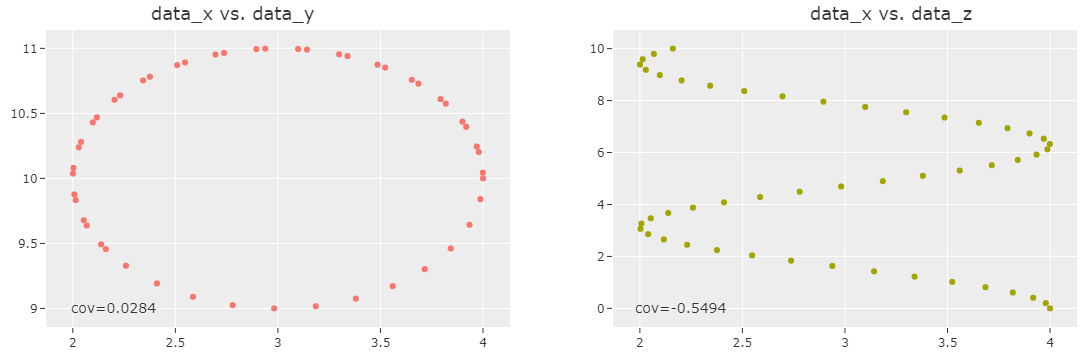

In [23]:
trace1 = go.Scatter(x=X[:, 0], y=X[:, 1], mode='markers') 
trace2 = go.Scatter(x=X[:, 0], y=X[:, 2], mode='markers')
# subplot titles are actually annotations, so set here
annotations = [
    dict(x=0.1, y=1.1, xref='paper', yref='paper', showarrow=False,
         text=f"data_x vs. data_y", font_size=18),
    dict(x=0.9, y=1.1, xref='paper', yref='paper', showarrow=False,
         text=f"data_x vs. data_z", font_size=18),
    dict(x=2.2, y=9, xref='x1', yref='y1', showarrow=False,
         text=f"cov={covariance_matrix[0, 1]:.4f}", font_size=14),
    dict(x=2.2, y=0, xref='x2', yref='y2', showarrow=False,
         text=f"cov={covariance_matrix[0, 2]:.4f}", font_size=14),
]
layout = dict(
    height=350, width=800, autosize=False,
    margin=dict(l=10, r=10, b=10, t=30),
    template="ggplot2", showlegend=False,
    xaxis={"fixedrange": True}, yaxis={"fixedrange": True}, 
    xaxis2={"fixedrange": True}, yaxis2={"fixedrange": True}, 
)

fig = make_subplots(rows=1, cols=2)
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.update_layout(layout, annotations=annotations)
fig.show(config={'displayModeBar': False})

# x and y are not linearly correlated, so covariance is close to zero (so will be the correlation)
# x and z are somehow linearly correlated, but the relationship can be better interpreted as non-linear

> Another way to compute _Covariance Matrox_ 

+ Given a matrix $A$, its covariance matrix is $A^T \cdot A$ divided by $\text{number of samples} - 1$
 + $A^T \cdot A$ returns the _raw scores_
 + divided by $\text{number of samples} - 1$ returns the _deviation scores_

In [11]:
np.cov(data, rowvar=False)

array([[ 0.53718562,  0.02840574, -0.54944278],
       [ 0.02840574,  0.44956238, -0.16253227],
       [-0.54944278, -0.16253227,  8.85047897]])

In [13]:
np.dot(data.transpose(), data) / data.shape[0]
# (3, 50) x (50, 3), slight difference by the denominator

array([[ 0.52644191,  0.02783762, -0.53845392],
       [ 0.02783762,  0.44057113, -0.15928162],
       [-0.53845392, -0.15928162,  8.67346939]])

In [14]:
np.dot(data.transpose(), data) / (data.shape[0] - 1)
# (3, 50) x (50, 3)

array([[ 0.53718562,  0.02840574, -0.54944278],
       [ 0.02840574,  0.44956238, -0.16253227],
       [-0.54944278, -0.16253227,  8.85047897]])

### 2. Principal Components are "orthogonal" to each other

+ i.e., perpendicular to each other
+ the orthogonal makes sure the two are NOT correlated
  + i.e. correlation between two transformed data = 0
  + i.e. cosine similarity between two vectors = 0

In [24]:
# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t) + 3 , np.sin(t) + 10, t # transform to all >= 0

X = np.c_[x, y, z]; row_index = np.array(range(X.shape[0]))
display(X.shape)

(50, 3)

In [25]:
eigen_vals, eigen_vecs, reduced_X_2d = numpy_pca(X, 2, scaled=False) # no need to scale with helix data
display(reduced_X_2d.shape)
eigen_vals, eigen_vecs

(50, 2)

(array([8.88982399, 0.50624339, 0.44115959]),
 array([[-6.56922925e-02, -9.56671463e-01, -2.83662185e-01],
        [-1.94326286e-02, -2.82995775e-01,  9.58924275e-01],
        [ 9.97650688e-01, -6.85062358e-02,  1.38903290e-16]]))

In [26]:
pc1 = eigen_vecs[:, 0]
pc2 = eigen_vecs[:, 1]

pc1_data = reduced_X_2d[:, 0]
pc2_data = reduced_X_2d[:, 1]

> **Correlation** between two transformed data:   
> sum of (the product of two centerd data),  divided by squared root of (product between two squared & centered data)  


In [27]:
r = np.corrcoef(pc1_data, pc2_data)
display(np.isclose(r[0, 1], 0)) # is close to 0 at very small tolerance
r
# ignore the diagonal values, that's the correlation with self
# this shows the correlation is close to 0, i.e. the two are transformed data not correlated

True

array([[ 1.00000000e+00, -2.53946075e-16],
       [-2.53946075e-16,  1.00000000e+00]])

In [28]:
a = pc1_data - np.mean(pc1_data)
b = pc2_data - np.mean(pc2_data)

sum(a * b) / np.sqrt(sum(a**2) * sum(b**2)) # close to np.corrcoef

-2.7769063643519433e-16

> **Cosine similarity** between two eigenvectors:   
> dot product between two vectors, divdied by product of vector's norm  

In [29]:
from scipy import spatial
1 - spatial.distance.cosine(pc1, pc2) # 1 - cosine distance = cosine similarity

0.0

In [30]:
cos_sim  = np.dot(pc1, pc2) / (np.linalg.norm(pc1) * np.linalg.norm(pc2))
display(np.isclose(cos_sim, 0)) # the cosine similarty is close to 0, i.e. not similar at all
cos_sim 

True

-2.775557561562893e-17

In [31]:
norm_pc1 = np.sqrt(sum(pc1 ** 2))
norm_pc2 = np.sqrt(sum(pc2 ** 2))

sum(pc1 * pc2) / (norm_pc1 * norm_pc2) # same as above

-2.775557561562893e-17

In [32]:
# plot the vectors for cosine?

### 3. Singular Value Decomposition

+ [Natural Language Processing in Action](https://www.manning.com/books/natural-language-processing-in-action)
+ An algorithm for decomposing any matrix into "three factors"
  + these three factors (matrices) can be multiplied together to recreate the original matrix 
+ Given a matrix $A$, decompose it into three factors: $U$, $S$ and $V$; 
  + where $A_{m × n} = U_{m × m} \cdot S_{m × n} \cdot V_{n × n}^{T}$
+ TODO
  
  

### 4. Eigenvalues and Eigenvectors

+ TODO

## References

Eigenvalues and Eigenvectors

+ https://www.thejuliagroup.com/blog/factor-analysis-and-eigenvalues/
+ https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
+ https://medium.com/@jonathan_hui/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491
+ https://medium.com/@jonathan_hui/machine-learning-linear-algebra-eigenvalue-and-eigenvector-f8d0493564c9
+ https://math.stackexchange.com/questions/127500/what-is-the-difference-between-singular-value-and-eigenvalue

PCA  

+ https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca
+ https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
+ https://github.com/scikit-learn/scikit-learn/blob/bac89c2/sklearn/decomposition/pca.py#L434
+ https://sebastianraschka.com/Articles/2014_pca_step_by_step.html

PCA Plotting

+ https://stackoverflow.com/questions/13224362/principal-component-analysis-pca-in-python
+ https://stackoverflow.com/questions/49957601/how-can-i-draw-3d-plane-using-pca-in-python


Covariance 

+ https://stattrek.com/matrix-algebra/covariance-matrix.aspx